In [1]:
# Clean imports that we don't use

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
import re
import os
import sys
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
!ls CellData/chest_xray

test
train


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.2.0


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [5]:
names_file = tf.io.gfile.glob(str('CellData/chest_xray/train/*/*'))

In [6]:
names_file.extend(tf.io.gfile.glob(str('CellData/chest_xray/train/*/*')))

In [7]:
labels_names = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] for item
                         in tf.io.gfile.glob(str("CellData/chest_xray/train/*"))][:2])

In [8]:
print(labels_names)

['NORMAL' 'PNEUMONIA']


In [9]:
train_names_file, val_names_file = train_test_split(names_file, test_size=0.18)

In [10]:
number_normal = len([names for names in train_names_file if labels_names[0] in names])

In [11]:
number_pneumonia = len([names for names in train_names_file if labels_names[1] in names])

In [12]:
print("The number of images with pneumonia is {} and the number of the images without it is {}"
      .format(number_pneumonia, number_normal))

The number of images with pneumonia is 6375 and the number of the images without it is 2205


In [13]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_names_file)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_names_file)

train_count = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(train_count))

val_count = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(val_count))

Training images count: 8580
Validating images count: 1884


In [14]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


In [15]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [16]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [17]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [18]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [19]:
test_list_ds = tf.data.Dataset.list_files(str('CellData/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [20]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [21]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [30]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("Pneumonia")
        else:
            plt.title("Normal")
        plt.axis("off")

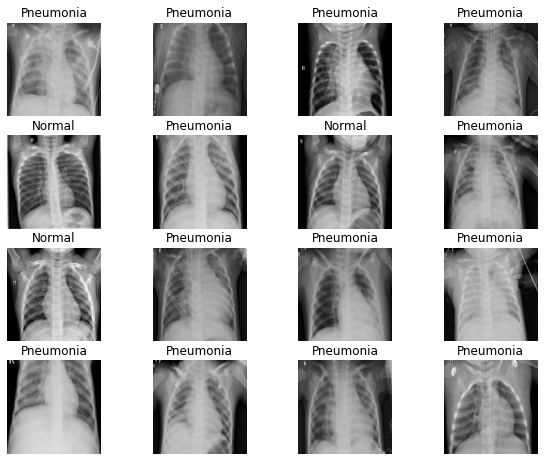

In [31]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [32]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [33]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [34]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [35]:
initial_bias = np.log([number_pneumonia/number_normal][0])
initial_bias

1.0616565821456805

In [36]:
weight_for_0 = (1 / number_normal)*(train_count)/2.0 
weight_for_1 = (1 / number_pneumonia)*(train_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


In [37]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=train_count // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=val_count // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
431/536 [=======================>......] - ETA: 1:26 - loss: 0.3402 - accuracy: 0.8414 - precision: 0.9596 - recall: 0.8218